In [1]:
import torch, pickle, time, os
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# if torch.cuda.is_available():
#     from accelerate import Accelerator
#     accelerator = Accelerator()
#     device = accelerator.device
### accelerate huggingface to GPU

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['medium_beforeafter',
 'medium_all_q_diffbeforeafter',
 'test_beforeafter',
 'test_all_smass',
 'transformers',
 'medium_all_q',
 'test_variance',
 'small_all_q_variancehalomass',
 'medium_all',
 'test',
 'one_all_q',
 'small_all_q']

In [3]:
case='medium_all_q'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))

In [31]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Our final linear layer will define our output
        self.bn = BatchNorm1d(num_features=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)   

          # 2. Readout layer
#         x = global_max_pool(x, batch)  ## Miles says use sumpool
#         x = global_mean_pool(x, batch)
#         x=concat(x1,x2)
        x = global_add_pool(x, batch)  ## Miles says use sumpool

#         x = F.dropout(x, p=0.1, training=self.training)

#         x = self.lin1(self.bn(x))
        x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

False

In [32]:
criterion = torch.nn.MSELoss()
n_epochs=100
batch_size=64
split=0.8
np.random.shuffle(data)
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]

In [33]:
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# _, _, test_loader = accelerator.prepare(model, optimizer, train_loader)
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

# Initialize our train function
def train():
    model.train()
 
    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y.view(-1,1)) 
        loss.backward()
#         accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
 # test function
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
#         print(out)
        correct += (torch.square(out - dat.y.view(-1,1))).sum() 
    return correct / len(loader.dataset) 
tr_acc, te_acc=[],[]
start=time.time()
for epoch in range(n_epochs):
    train()
    
    if (epoch+1)%2==0:
        train_acc = test(train_loader).detach().numpy()
        test_acc = test(test_loader).detach().numpy()
        tr_acc.append(train_acc)
        te_acc.append(test_acc)
        print(f'Epoch: {epoch+1:03d}, Train scatter: {5*np.sqrt(train_acc):.4f}, Test scatter: {5*np.sqrt(test_acc):.4f}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")

Epoch: 002, Train scatter: 10.6741, Test scatter: 11.4268
Epoch: 004, Train scatter: 8.2110, Test scatter: 5.6965
Epoch: 006, Train scatter: 6.3588, Test scatter: 5.6331
Epoch: 008, Train scatter: 6.8857, Test scatter: 5.7438
Epoch: 010, Train scatter: 8.3598, Test scatter: 6.3189
Epoch: 012, Train scatter: 3.9865, Test scatter: 3.3109
Epoch: 014, Train scatter: 3.4158, Test scatter: 3.2665
Epoch: 016, Train scatter: 2.9169, Test scatter: 2.8195
Epoch: 018, Train scatter: 3.6635, Test scatter: 3.1786
Epoch: 020, Train scatter: 2.5038, Test scatter: 2.2520
Epoch: 022, Train scatter: 2.1496, Test scatter: 2.0873
Epoch: 024, Train scatter: 3.3670, Test scatter: 2.9218
Epoch: 026, Train scatter: 5.3429, Test scatter: 4.4833
Epoch: 028, Train scatter: 6.2909, Test scatter: 4.4377
Epoch: 030, Train scatter: 3.3339, Test scatter: 2.6819
Epoch: 032, Train scatter: 1.6184, Test scatter: 1.6638
Epoch: 034, Train scatter: 1.6075, Test scatter: 1.5777
Epoch: 036, Train scatter: 1.7158, Test scatte

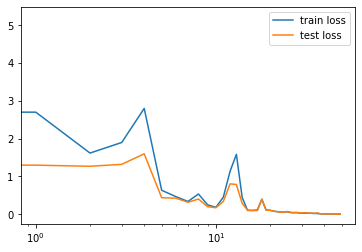

In [34]:
plt.plot(tr_acc, label='train loss')
plt.plot(te_acc, label='test loss')
plt.xscale('log')
plt.legend()

In [35]:
ys, pred=[],[]
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
        pred.append(5*out.view(1,-1).detach().numpy())
        ys.append(5*np.array(dat.y)) 
test(test_loader)
# test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

[Text(0.5, 1.0, 'Residuals, scatter is 0.42'), Text(0.5, 0, 'log M_*')]

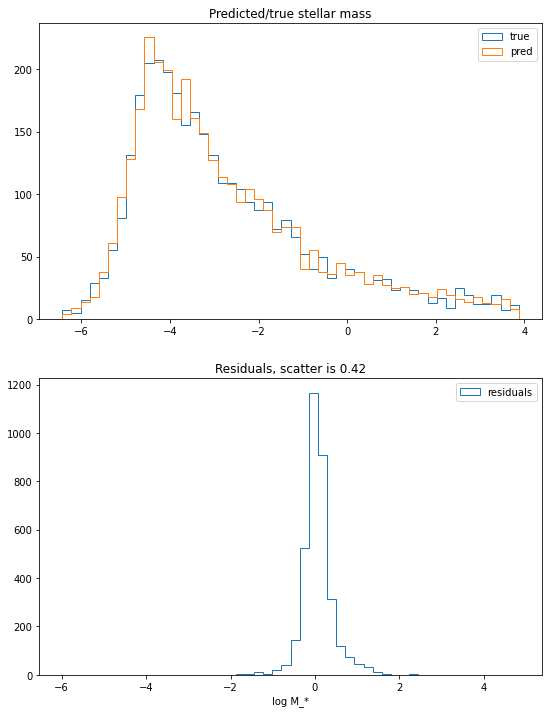

In [36]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
ax[0].hist(ys, bins=bins, range=(np.min(np.hstack([ys,pred]))/1.5,np.max(np.hstack([ys,pred]))/1.5), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.min(np.hstack([ys,pred]))/1.5,np.max(np.hstack([ys,pred]))/1.5), label='pred', histtype='step')
ax[1].hist((ys-pred), bins=bins,range=(np.min((ys-pred))/1.5,np.max((ys-pred))/1.5),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title='Predicted/true stellar mass')
ax[1].set(title=f'Residuals, scatter is {np.std(ys-pred):.2f}', xlabel='log M_*')

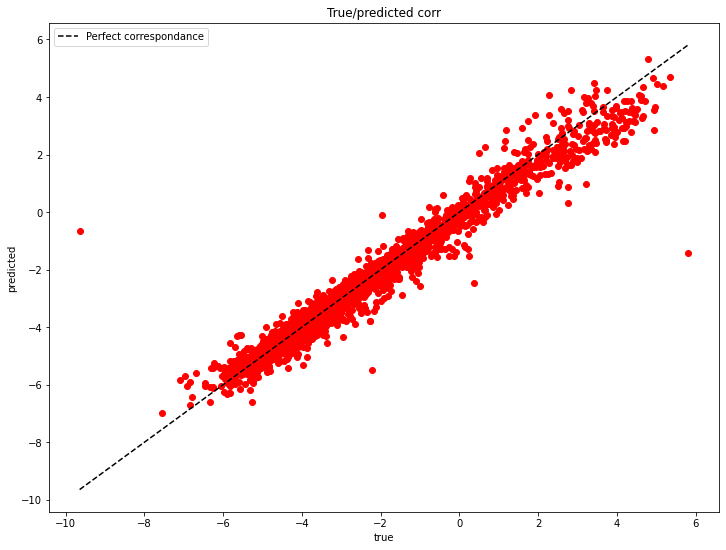

In [37]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [20]:
x,y=[], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())    

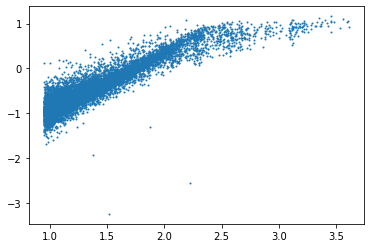

In [21]:
plt.plot(x, y, 'o', markersize=1) 

In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools